### StatsModelsを用いた回帰分析 (Linear regression with StatsModels)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy.stats as ss
import sklearn.preprocessing as sp
import itertools
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [13]:
# データを読み込む
data = pd.read_csv("data/cl1/Ikebukuro.csv", delimiter=",", comment="#")
print(data.head())

      Fee  Walk   Size  Year
0   59500     7  21.13     0
1   58000     6  21.17     0
2   57500     6  21.11     0
3  110000     5  42.52     4
4  106000     8  51.65    28


In [4]:
x = data[["Walk", "Size", "Year"]] # 独立（説明）変数 independent variable"high_school"
y = data["Fee"] # 従属（目的）変数 dependent  variable
#plt.scatter(x,y) # 散布図をプロット Scatter plot 
#plt.xlabel("Distance")
#plt.ylabel("Damage")
#plt.show()

In [5]:
# モデルの設定 Construct a linear regression model
model = sm.OLS(y, sm.add_constant(x))

# ラベル名を用いるときのモデルの設定 Construct a linear regression model
#model = smf.ols(formula = "damage ~ distance", data = data)

# 回帰分析の実行 Execute linear  regression 
results = model.fit()

# 結果を表示　Print results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    Fee   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     82.90
Date:                Tue, 22 Jan 2019   Prob (F-statistic):           1.51e-26
Time:                        17:14:53   Log-Likelihood:                -1073.4
No. Observations:                 100   AIC:                             2155.
Df Residuals:                      96   BIC:                             2165.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.064e+04   3757.141     10.818      0.0

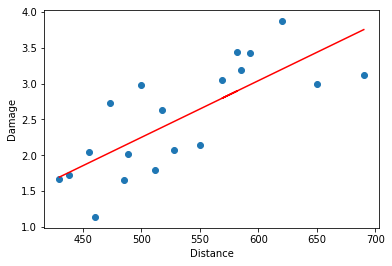

In [5]:
b = results.params[0] # 回帰式の切片 Intercept
a = results.params[1] # 回帰式の傾き Regression coefficient

plt.scatter(x,y) # 散布図をプロット Scatter plot
plt.plot(x, a*x+b, color="red") # 回帰直線をプロット  Plot regression line
plt.xlabel("Distance")
plt.ylabel("Damage")
plt.show()

In [7]:
def step_aic(model, exog, endog, **kwargs):
    """
    This select the best exogenous variables with AIC
    Both exog and endog values can be either str or list.
    (Endog list is for the Binomial family.)

    Note: This adopt only "forward" selection

    Args:
        model: model from statsmodels.formula.api
        exog (str or list): exogenous variables
        endog (str or list): endogenous variables
        kwargs: extra keyword argments for model (e.g., data, family)

    Returns:
        model: a model that seems to have the smallest AIC
    """

    # exog, endogは強制的にリスト形式に変換しておく
    exog = np.r_[[exog]].flatten()
    endog = np.r_[[endog]].flatten()
    remaining = set(exog)
    selected = []  # 採用が確定された要因

    # 定数項のみのAICを計算
    formula_head = ' + '.join(endog) + ' ~ '
    formula = formula_head + '1'
    aic = model(formula=formula, **kwargs).fit().aic
    print('AIC: {}, formula: {}'.format(round(aic, 3), formula))

    current_score, best_new_score = np.ones(2) * aic

    # 全要因を採択するか，どの要因を追加してもAICが上がらなければ終了
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:

            # 残っている要因を1つずつ追加したときのAICを計算
            formula_tail = ' + '.join(selected + [candidate])
            formula = formula_head + formula_tail
            aic = model(formula=formula, **kwargs).fit().aic
            print('AIC: {}, formula: {}'.format(round(aic, 3), formula))

            scores_with_candidates.append((aic, candidate))

        # 最もAICが小さかった要因をbest_candidateとする
        scores_with_candidates.sort()
        scores_with_candidates.reverse()
        best_new_score, best_candidate = scores_with_candidates.pop()

        # 候補要因追加でAICが下がったならば，それを確定要因として追加する
        if best_new_score < current_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score

    formula = formula_head + ' + '.join(selected)
    print('The best formula: {}'.format(formula))
    return model(formula, **kwargs).fit()

In [12]:
mod = step_aic(smf.ols, ["Walk", "Size", "Year"], ["Fee"], data=dat)


AIC: 2276.668, formula: Fee ~ 1
AIC: 2166.461, formula: Fee ~ Size
AIC: 2278.353, formula: Fee ~ Year
AIC: 2274.396, formula: Fee ~ Walk
AIC: 2156.026, formula: Fee ~ Size + Year
AIC: 2165.066, formula: Fee ~ Size + Walk
AIC: 2154.831, formula: Fee ~ Size + Year + Walk
The best formula: Fee ~ Size + Year + Walk


statsmodels.regression.linear_model.RegressionResultsWrapper

In [ ]:
for i in 

In [14]:
def Mahala2(vec_x, vec_mean, mat):
    length = mat.shape[0]
    vec_x = np.array(vec_x, dtype='float64')
    vec = np.asmatrix((vec_x - vec_mean).values.reshape(length, 1))
    inv = np.linalg.inv(mat) # 逆行列を求める　Compute the inverse of a matrix.
    mahala2 = vec.T.dot(inv.dot(vec)) 
    return mahala2[0, 0]

In [8]:
Sigma = np.asmatrix(data[["Walk", "Size", "Year"]].cov()) # 独立変数の分散共分散行列を求める． Variance-covariance matrix of IVs.
n = len(data) # 標本数. Sample size.
dfm = results.df_model # 独立変数の数（モデルの自由度）．　Number of IVs (Model degrees of freedom). 
t_0025 = ss.t.isf(q=0.05/2, df=n-dfm-1) # 自由度 n-dfm-1のt分布の上側2.5パーセント点(= ss.t.ppf(q=0.975, df=n-dfm-1))
vec_mean = data[["Walk", "Size", "Year"]].mean() # 独立変数の平均を求める　Find average of independent variables
print(vec_mean)

#観測値に対応する従属変数の信頼区間を求める Find CI of Y on observed values
X = np.array([1, 6,40,5]) #観測値の設定
hat_y=X.dot(results.params) # Xとresults.paramsの内積を求め従属変数の推定値を求める　Obtain estimated value of dependent variable

D2_0 = Mahala2([39, 16], vec_mean, Sigma) # マハラノビス距離の二乗を求める Squared Mahalanobis distance

Ve = results.scale #  残差変動の不偏分散． A scale factor for the covariance matrix.
Se_o = np.sqrt((1/n + D2_0 / (n-1)) * Ve) #観測値の場合　In case of observed value

ci_low = hat_y - t_0025 * Se_o# 下側信頼
ci_up = hat_y + t_0025 * Se_o # 上側信頼

print("理論値（theoretical value）:", hat_y)
print("理論値の信頼区間（CI of theoretical value）：({0},{1})".format(ci_low,ci_up))

#予測値（未観測値に対応する従属変数）の信頼区間を求める Find prediction interval of Y on unobserved values
X = np.array([1, 39, 16]) #未観測値の設定
hat_y=X.dot(results.params) # Xとresults.paramsの内積を求め従属変数の推定値を求める　Obtain estimated value of dependent variable

D2_0 = Mahala2([39, 16], vec_mean, Sigma) # マハラノビス距離の二乗を求める Squared Mahalanobis distance

Se_p = np.sqrt((1 + 1/n + D2_0 / (n-1)) * Ve) #未観測値の場合　In case of unobserved value

pi_low = hat_y - t_0025 * Se_p# 下側信頼
pi_up = hat_y + t_0025 * Se_p # 上側信頼

print("予測値（Predicted value）:", hat_y)
print("予測値の信頼区間（CI of predicted value）：({0},{1})".format(pi_low,pi_up))

KeyError: "['high' 'low'] not in index"

In [ ]:
cement = np.linspace(130, 180, 200) # 100から300までの等差数列を生成

hat_y = []
(Fly_ash, Water, Slag, Fine_Aggr, SP) = (260, 285, 115, 750, 9) # Wind, Tempの値を(10, 78)に固定.　Wind, Temp values are fixed to (10, 78).

for c in cement:
    X = np.array([1, c, Fly_ash, Water, Slag, Fine_Aggr, SP])
    hat_y.append(X.dot(f_res.params))# Xとresults.paramsの内積を求め従属変数の推定値を求める Obtain estimated value of dependent variable
plt.plot(cement, hat_y, label="Predicted value") # 予測値をプロット

D2 = []
for c in cement:
    D2_0 = Mahala2([c, Fly_ash, Water, Slag, Fine_Aggr, SP], vec_mean, Sigma) # マハラノビス距離の二乗を求める Squared Mahalanobis distance
    D2.append(D2_0)
D2 = np.array(D2)

Se_o = np.sqrt((1/n + D2 / (n-1)) * Ve) #観測値の場合　In case of observation value
Se_p = np.sqrt((1 + 1/n + D2 / (n-1)) * Ve) #未観測値の場合　In case of unobserved value

# 観測値に対応する従属変数の信頼区間をプロット
plt.plot(cement, hat_y - t_0025 * Se_o, "--g", label="95% theoritical confidence interval")
plt.plot(cement, hat_y + t_0025 * Se_o, "--g")

# 予測値の信頼区間をプロット
plt.plot(cement, hat_y - t_0025 * Se_p, "--r", label="95% prediction interval")
plt.plot(cement, hat_y + t_0025 * Se_p, "--r")

plt.xlabel("Cement")
plt.ylabel("Compressive Strength")
plt.legend()
plt.show()

In [6]:
num_cols = model.exog.shape[1]
vifs = [variance_inflation_factor(model.exog, i) for i in range(0, num_cols)]
pd.DataFrame(vifs, index=model.exog_names, columns=["VIF"])

,VIF
const,10.987350
Walk,1.017672
Size,1.045825
Year,1.030698


In [ ]:
X_scale = sp.scale(x)
y_scale = sp.scale(y)

# モデルの設定
mod = sm.OLS(y_scale, sm.add_constant(X_scale))

# 回帰分析の実行
res = mod.fit()

# 結果を表示
print(res.summary())

In [ ]:
df_scale_x = pd.DataFrame(X_scale, columns=["x1", "x2"])
df_scale_y = pd.DataFrame(y_scale, columns=["y"])